# Gradient Angle based approach

Instead of just using an edge map, we'll use an edge map with a gradient angle map to inform our hough transform.
Along the way, we notice we could even take subsets of the histogram of the gradient angles to slice out the lines associated mostly with the chessboards.

Populating the interactive namespace from numpy and matplotlib


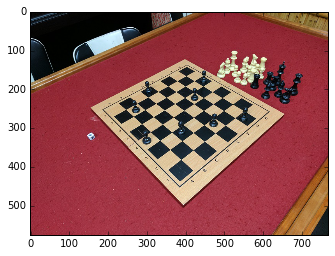

In [1]:
%pylab inline
from IPython.display import Image, display
import cv2
from io import BytesIO
import matplotlib.image as mpimg

def showarray(a, fmt='png'):
    """Expects 0-255 pixel values"""
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

filename = "6.jpg"
img_orig = mpimg.imread(filename)
img = cv2.imread(filename, 0) # gray
blurred = img
# blurred = cv2.bilateralFilter(img,35,75,75) # Smooth it down with a bilateral filter
plt.imshow(img_orig);

In [2]:
sobelx = cv2.Sobel(blurred,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(blurred,cv2.CV_64F,0,1,ksize=5)

# fig = plt.figure(figsize=(15,10))
# plt.imshow(sobelx)

In [3]:
grad_mag = sobelx**2+sobely**2
grad_phase = np.arctan2(sobely, sobelx) # from -pi to pi
# print(grad_phase.min(), grad_phase.max())
grad_phase[grad_mag < 1*np.mean(grad_mag.flatten())] = 0 # Remove phase from where gradient magnitude is less than the mean

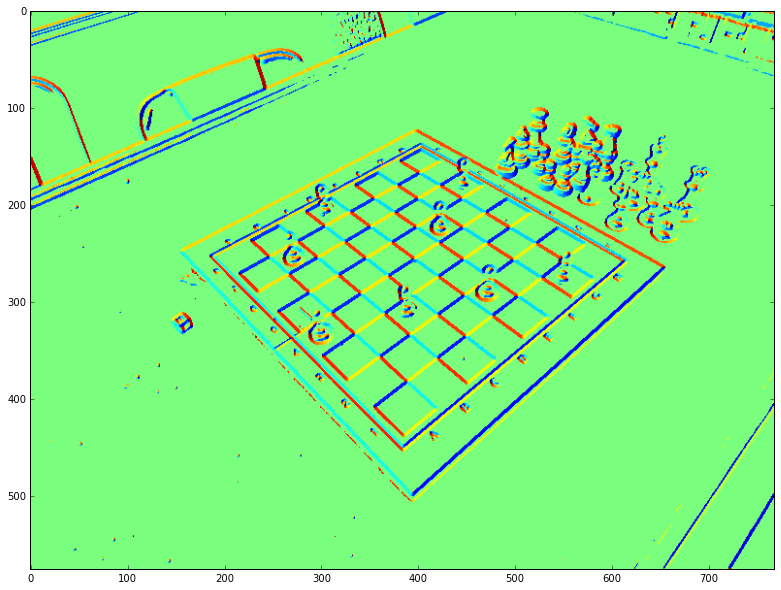

In [4]:
fig = plt.figure(figsize=(15,10))
plt.imshow(grad_phase)

(-179.93943365943778, 180.00000000000003, 0.0, 1654.0)

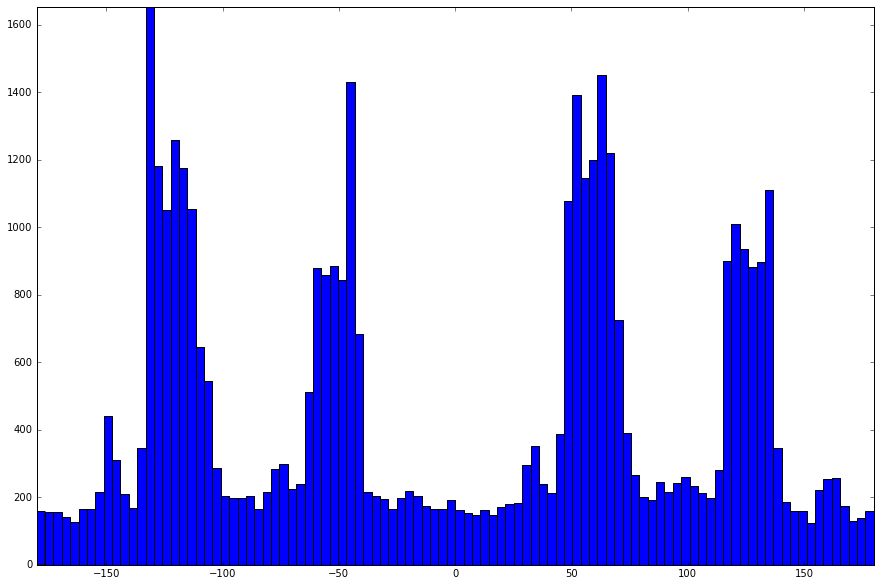

In [5]:
fig = plt.figure(figsize=(15,10))
a = plt.hist(180/np.pi * grad_phase.flatten()[grad_phase.flatten() != 0], bins=100);
axis('tight');
# (grad_mag.flatten()[:100]).shape

We'll also get an edge map from the blurred image, which we'll use as our inputs to our two hough transforms

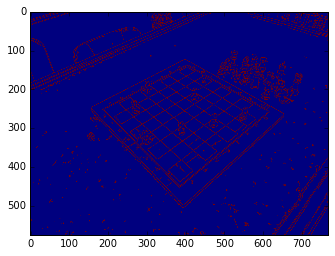

In [6]:
edges_blurred = cv2.Canny(np.uint8(blurred),50,150,apertureSize = 3)
plt.imshow(edges_blurred);

The naive hough transform introduces a lot of spurious lines over the image, making it difficult to find the right one.

# Informed Hough Transform
Take the hough transform, but instead we severely limit the angles splatted to as a function of the estimated angle. 

We should also weight by the gradient magnitude

In [9]:
def getBinIdx(bins, val):
    a = val < bins
    if any(a):
        return np.argmax(a)
    return len(bins)-1

def informedHough(bin_img, gradient_phase_img, gradient_magnitude_img, theta_bin_size=100, rho_bin_size=100, inform_range=5):
    """Return informed hough space of input binary image"""
    thetas = np.linspace(-np.pi,np.pi,theta_bin_size)
    rhos = np.linspace(-max(bin_img.shape),max(bin_img.shape),rho_bin_size)
    hough_space = np.zeros([theta_bin_size, rho_bin_size])

    for i in range(bin_img.shape[0]):
        for j in range(bin_img.shape[1]):
            if bin_img[i,j]:
                g = gradient_phase_img[i,j]
                theta_idx = getBinIdx(thetas, g)
                theta_left = max(0,theta_idx - inform_range)
                theta_right = min(len(thetas)-1,theta_idx + inform_range)
                
                for t,theta in enumerate(thetas[theta_left:theta_right]):
                    rho = j*np.cos(theta) + i*np.sin(theta)
                    rho_idx = getBinIdx(rhos, rho)
                    hough_space[theta_idx-inform_range+t, rho_idx] += np.sqrt(gradient_magnitude_img[i,j])
#                     hough_space[theta_idx-inform_range+t, rho_idx] += 1
    return (hough_space, thetas, rhos)

In [10]:
grad_phase = np.arctan2(sobely, sobelx) # Get original un-masked gradient phase map
h2, thetas, rhos = informedHough(edges_blurred, grad_phase, grad_mag, theta_bin_size=4*360, rho_bin_size=4*360, inform_range=10)

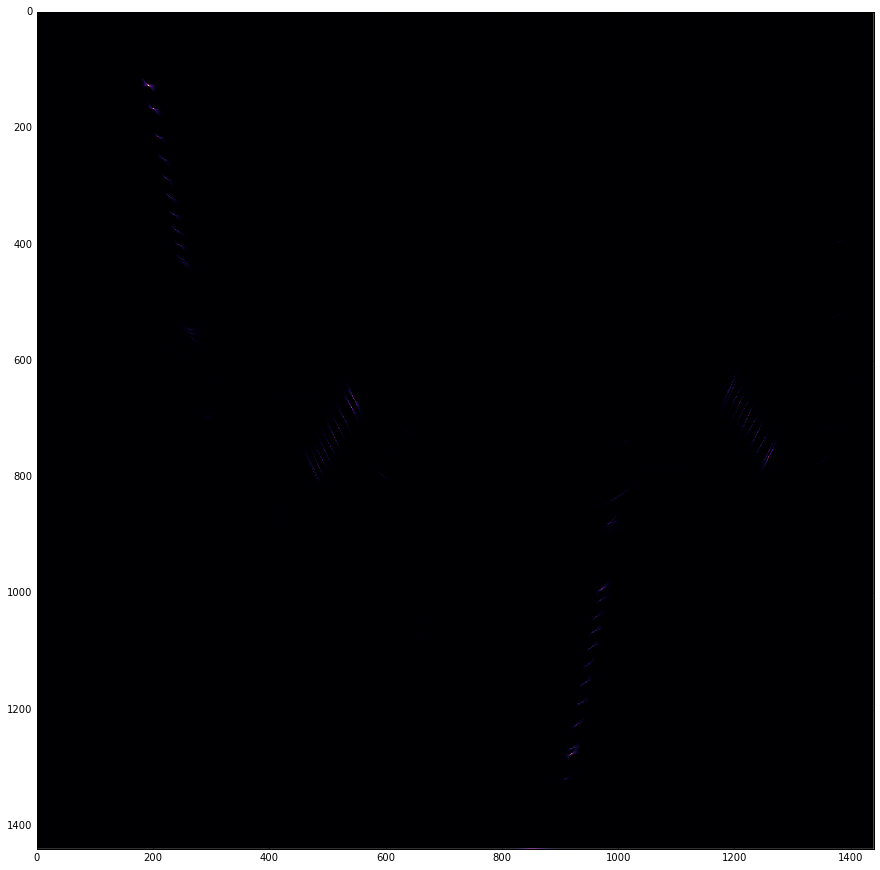

In [11]:
fig = plt.figure(figsize=(15,15))
# plt.imshow(h2.T, interpolation='none', extent=[thetas[0]*180/np.pi,thetas[-1]*180/np.pi,rhos[0],rhos[-1]])
plt.imshow(h2.T, interpolation='none', cmap=cm.inferno)
plt.axis('normal')
plt.axis('tight');

Notice how there's four sets of points, 2 for theta ranges -pi to 0, and 2 for 0 to pi, knowing that chessboards have alternating gradients along chessboard lines, we can actually multiply the negative theta positive rho quadrant with the positive theta, negative rho quadrant to find points that have a strong positive AND negative gradient.

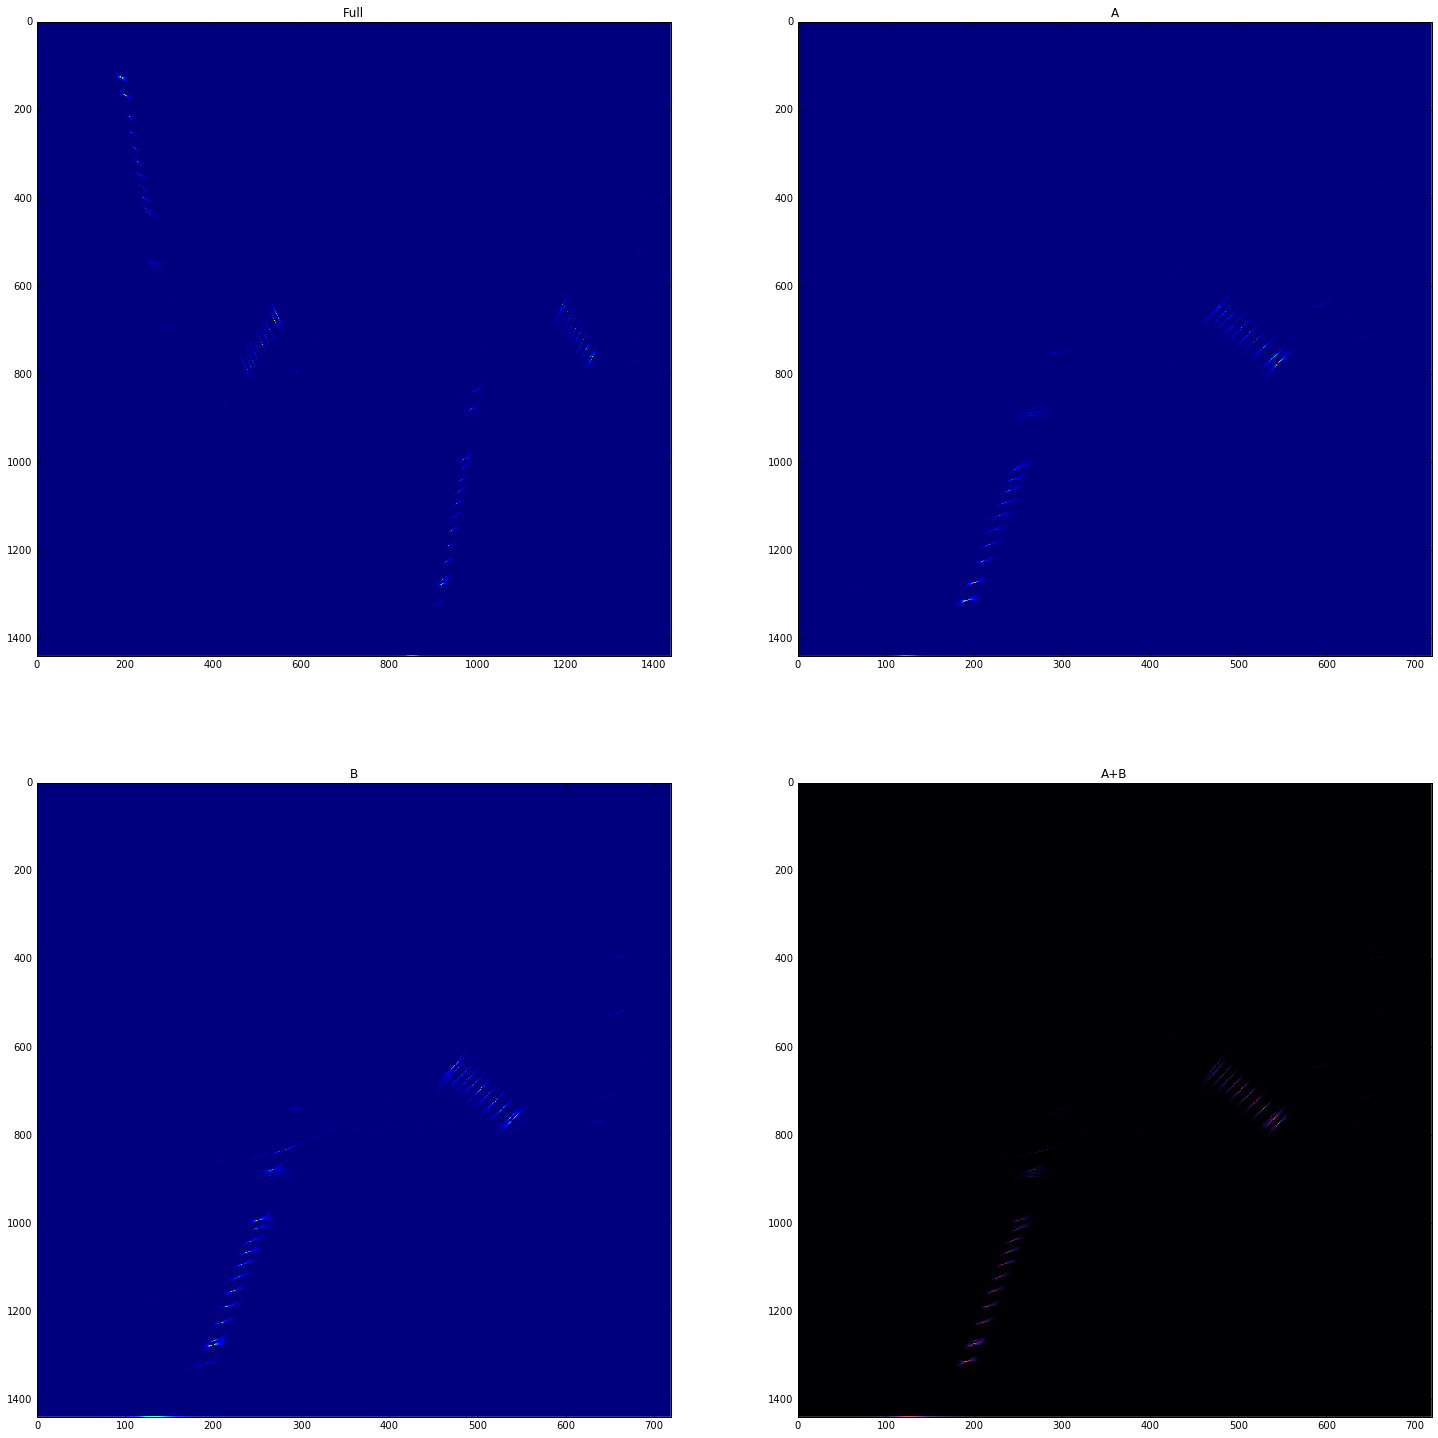

In [12]:
[r,c] = h2.shape
a = np.fliplr(h2[:int(r/2),:])
b = h2[int(r/2):,:]
h3 = a + b

fig = plt.figure(figsize=(25,25))
plt.subplot(221)
plt.imshow(h2.T, interpolation='none')
plt.axis('normal')
plt.axis('tight')
plt.title('Full')

plt.subplot(222)
plt.imshow(a.T, interpolation='none')
plt.axis('normal')
plt.axis('tight')
plt.title('A')

plt.subplot(223)
plt.imshow(b.T, interpolation='none')
plt.axis('normal')
plt.axis('tight')
plt.title('B')

plt.subplot(224)
plt.imshow(h3.T, interpolation='none', cmap=cm.inferno)
plt.axis('normal')
plt.axis('tight')
plt.title('A+B');

# Combined Informed Hough Transform Result

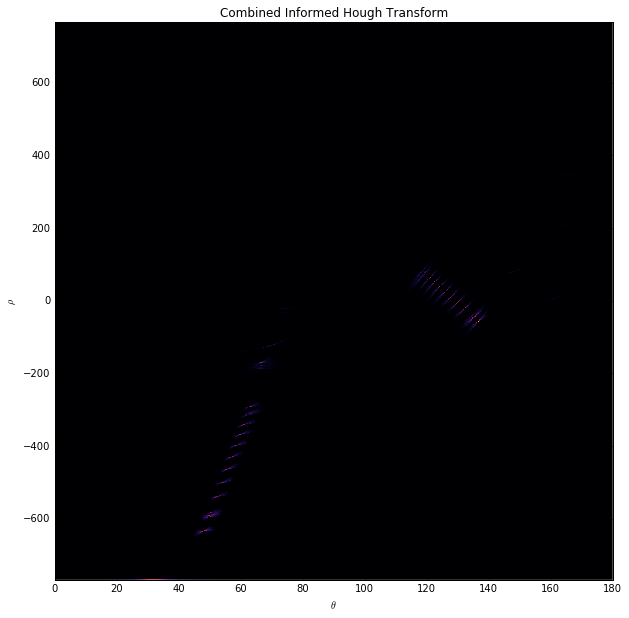

In [13]:
fig = plt.figure(figsize=(10,10))
plt.imshow(h3.T, interpolation='none', extent=[0,thetas[-1]*180/np.pi,rhos[0],rhos[-1]], cmap=cm.inferno)
plt.axis('normal')
plt.axis('tight')
plt.xlabel(r'$\theta}$')
plt.ylabel(r'$\rho}$')
plt.title('Combined Informed Hough Transform');

This works *much* better. The chessboard lines show up clearly as sets of points in a line.

## Hough Peak Detection
Find max values, suppress values where stronger values exist in region, do for top N lines, plot lines in image, should be mostly chessboard lines.


In [14]:
def isLocalMax(h,ti,tj,winsize=5):
    test_val = h[ti,tj]
    # Definitely not if no hits to hough at this point
    if (test_val == 0):
        return False
    
    # Construct neighborhood
    ti_a = max(0,ti-winsize)
    ti_b = min(h.shape[0],ti+winsize)
    tj_a = max(0,tj-winsize)
    tj_b = min(h.shape[1],tj+winsize)

    # Compare neighborhood to point
    neighborhood = h[ti_a:ti_b,tj_a:tj_b] >= test_val
    
    # Ignore self
    neighborhood[winsize-max(0,winsize-ti), winsize-max(0,winsize-tj)] = False
    return (not np.any(neighborhood))

In [15]:
input_h = h3.copy()

# Generate peak image
local_max_img = np.zeros(input_h.shape)
for i in range(input_h.shape[0]):
    for j in range(input_h.shape[1]):
        if isLocalMax(input_h, i, j):
            local_max_img[i,j] = input_h[i,j]

# fig = plt.figure(figsize=(5,5))
# plt.imshow(local_max_img.T > 0, interpolation='none', cmap=cm.inferno);

Now that we have a suppressed hough image with only the peaks showing, we find the peak points and sort them in order of strongest to weakest.

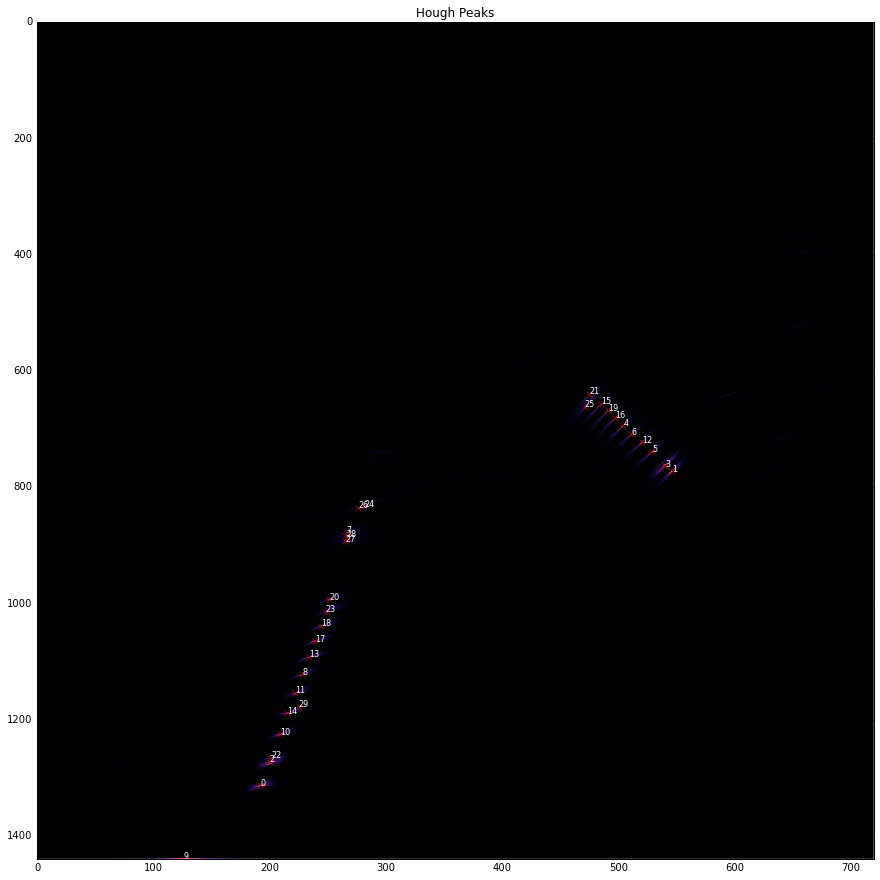

In [16]:
peaks = np.argwhere(local_max_img)

peak_mags = local_max_img[peaks[:,0],peaks[:,1]]
peak_order = np.argsort(peak_mags)[::-1] # Strongest to weakest

# Sort peaks by strength
peaks = peaks[peak_order,:]

fig = plt.figure(figsize=(15,15))
n_peaks = min(peaks.shape[0],30)
plt.imshow(input_h.T, interpolation='none', cmap=cm.inferno)
plt.plot(peaks[:n_peaks,0], peaks[:n_peaks, 1], 'xr')
for idx, [px, py] in enumerate(peaks[:n_peaks,:]):
    plt.text(px, py,'%s' % idx, color='white', size=8)
plt.axis('normal')
plt.axis('tight')
plt.title('Hough Peaks');

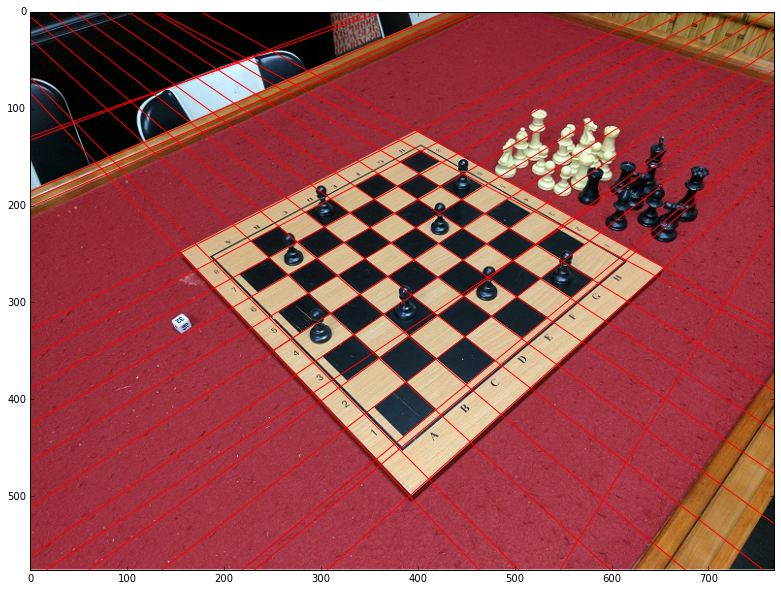

In [17]:
fig = plt.figure(figsize=(15,10))
plt.imshow(img_orig);

for theta_, rho_ in peaks[:n_peaks,:]:
    theta = thetas[theta_ + int(r/2)]
    rho = rhos[rho_]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    plt.plot([x1,x2], [y1,y2],'r-')

plt.axis([0,img_orig.shape[1], img_orig.shape[0], 0]);

## TODO : Use Windows for chessboard hotspot detection

Ways of removing non-chessboard lines, the idea is to take a histogram within a windowed region, and score higher based on if there's 2(4) strong gradients only.